In [1]:
# ========== IMPORTS AND SETUP ==========
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings
# Import custom modules
from config import Config
from detector import MediaPipeProcessor

warnings.filterwarnings("ignore")

# Setup
config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

print(f"[INFO] Device: {device}")
print(f"[INFO] Config loaded")


2025-07-17 18:19:27.887396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 18:19:27.899484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752751167.914095   19298 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752751167.918345   19298 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 18:19:27.933894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[INFO] Device: cuda
[INFO] Config loaded


In [2]:
# ========== LOAD LABELS FROM CSV ==========
def load_labels_from_csv(csv_file=None):
    """Load labels from CSV file"""
    if csv_file is None:
        csv_file = config.data.input_csv_file
    
    df = pd.read_csv(csv_file)
    video_to_label_mapping = {}
    
    for _, row in df.iterrows():
        label_id = row['id']
        videos_str = row['videos']
        video_files = [v.strip() for v in videos_str.split(',')]
        
        for video_file in video_files:
            video_base = os.path.splitext(video_file)[0]
            video_to_label_mapping[video_base] = label_id
    
    unique_labels = sorted(df['id'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    
    print(f"[INFO] Found {len(unique_labels)} classes: {unique_labels}")
    print(f"[INFO] Created mapping for {len(video_to_label_mapping)} videos")
    
    return video_to_label_mapping, label_to_idx, unique_labels

# Load labels
video_to_label_mapping, label_to_idx, labels = load_labels_from_csv()
num_classes = len(labels)

[INFO] Found 15 classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[INFO] Created mapping for 105 videos


In [3]:
# ========== DATASET CLASS ==========
class SignLanguageDataset(Dataset):
    """Dataset for Sign Language Recognition with GCN format"""
    
    def __init__(self, keypoints_dir, video_to_label_mapping, label_to_idx, 
                 sequence_length=None, split_type='train', train_split=None):
        
        # Use config parameters
        self.sequence_length = sequence_length or config.thgc_lstm.sequence_length
        train_split = train_split or config.training.train_split
        
        self.keypoints_dir = keypoints_dir
        self.video_to_label_mapping = video_to_label_mapping
        self.label_to_idx = label_to_idx
        
        # Find valid files
        available_files = [f for f in os.listdir(keypoints_dir) if f.endswith(config.data.keypoints_ext)]
        valid_files = []
        for file in available_files:
            base_name = os.path.splitext(file)[0]
            if base_name in video_to_label_mapping:
                valid_files.append(base_name)
        
        # Split into train/val
        np.random.shuffle(valid_files)
        split_idx = int(len(valid_files) * train_split)
        
        if split_type == 'train':
            self.files = valid_files[:split_idx]
        else:
            self.files = valid_files[split_idx:]
        
        print(f"[INFO] {split_type.upper()} dataset: {len(self.files)} files")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        base_filename = self.files[idx]
        
        # Load keypoints
        kp_path = os.path.join(self.keypoints_dir, f"{base_filename}{config.data.keypoints_ext}")
        kp_sequence = np.load(kp_path)
        
        # Reshape to (T, V, C) for GCN: T=time, V=vertices/joints, C=coordinates
        if len(kp_sequence.shape) == 2:
            T, features = kp_sequence.shape
            expected_features = config.thgc_lstm.num_vertices * config.thgc_lstm.in_channels
            if features == expected_features:
                kp_sequence = kp_sequence.reshape(T, config.thgc_lstm.num_vertices, config.thgc_lstm.in_channels)
        
        # Pad/truncate to sequence_length
        if kp_sequence.shape[0] != self.sequence_length:
            if kp_sequence.shape[0] < self.sequence_length:
                pad_length = self.sequence_length - kp_sequence.shape[0]
                padding = np.zeros((pad_length, kp_sequence.shape[1], kp_sequence.shape[2]))
                kp_sequence = np.concatenate([kp_sequence, padding], axis=0)
            else:
                kp_sequence = kp_sequence[:self.sequence_length]
        
        # Get label
        label_id = self.video_to_label_mapping[base_filename]
        label_idx = self.label_to_idx[label_id]
        
        return torch.from_numpy(kp_sequence).float(), torch.tensor(label_idx, dtype=torch.long)

# Create datasets
keypoints_dir = config.data.keypoints_output_dir
train_dataset = SignLanguageDataset(keypoints_dir, video_to_label_mapping, label_to_idx, 
                                   split_type='train')
val_dataset = SignLanguageDataset(keypoints_dir, video_to_label_mapping, label_to_idx, 
                                 split_type='val')

[INFO] TRAIN dataset: 94 files
[INFO] VAL dataset: 11 files


In [4]:
# ========== DATA LOADERS ==========
def create_data_loaders(train_dataset, val_dataset, batch_size=None):
    """Create data loaders"""
    batch_size = batch_size or config.training.batch_size
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"[INFO] Train batches: {len(train_loader)}")
    print(f"[INFO] Val batches: {len(val_loader)}")
    print(f"[INFO] Batch size: {batch_size}")
    
    return train_loader, val_loader

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# Test data loader
for kp_batch, lbl_batch in train_loader:
    print(f"[INFO] Batch keypoints shape: {kp_batch.shape}")  # (B, T, V, C)
    print(f"[INFO] Batch labels shape: {lbl_batch.shape}")    # (B,)
    break

[INFO] Train batches: 12
[INFO] Val batches: 2
[INFO] Batch size: 8
[INFO] Batch keypoints shape: torch.Size([8, 60, 75, 2])
[INFO] Batch labels shape: torch.Size([8])


In [5]:
# ========== ADJACENCY MATRIX FOR SKELETON GRAPH ==========
def create_adjacency_matrix(num_vertices=None):
    """Create adjacency matrix for skeleton graph"""
    N = num_vertices or config.thgc_lstm.num_vertices
    A = np.zeros((N, N), dtype=np.float32)
    
    # MediaPipe connections for pose (33 points)
    POSE_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
        (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
        (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
        (11, 23), (12, 24), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28),
        (27, 29), (28, 30), (29, 31), (30, 32), (27, 31), (28, 32)
    ]
    
    # Hand connections (21 points each)
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # index
        (0, 9), (9, 10), (10, 11), (11, 12),  # middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # ring
        (0, 17), (17, 18), (18, 19), (19, 20),  # pinky
        (5, 9), (9, 13), (13, 17)  # palm
    ]
    
    # Add pose connections
    for i, j in POSE_CONNECTIONS:
        if i < 33 and j < 33:
            A[i, j] = 1
            A[j, i] = 1
    
    # Add left hand connections (offset 33)
    for i, j in HAND_CONNECTIONS:
        u, v = i + 33, j + 33
        if u < N and v < N:
            A[u, v] = 1
            A[v, u] = 1
    
    # Add right hand connections (offset 54)
    for i, j in HAND_CONNECTIONS:
        u, v = i + 54, j + 54
        if u < N and v < N:
            A[u, v] = 1
            A[v, u] = 1
    
    # Add self-loops
    np.fill_diagonal(A, 1)
    
    # Normalize adjacency matrix
    D = np.diag(np.sum(A, axis=1) ** -0.5)
    A_norm = D @ A @ D
    
    return torch.tensor(A_norm, dtype=torch.float32)

# Create adjacency matrix
A = create_adjacency_matrix()
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.thgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [6]:
# ========== THGC-LSTM MODEL ==========
class GCNLayer(nn.Module):
    """Graph Convolutional Layer"""
    def __init__(self, in_features, out_features, A, use_batch_norm=True):
        super(GCNLayer, self).__init__()
        self.A = A
        self.fc = nn.Linear(in_features, out_features)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        # x: (B, T, V, C)
        B, T, V, C = x.size()
        x = x.reshape(B * T, V, C)  # (B*T, V, C)
        A = self.A.to(x.device)
        x = torch.matmul(A, x)   # (B*T, V, C)
        x = self.fc(x)           # (B*T, V, out_features)
        x = x.reshape(B, T, V, -1)  # (B, T, V, out_features)
        
        if self.use_batch_norm:
            x = x.permute(0, 3, 1, 2)  # (B, out_features, T, V)
            x = self.bn(x.contiguous().view(B, -1, T * V))  # Batch norm
            x = x.view(B, -1, T, V).permute(0, 2, 3, 1)  # Back to (B, T, V, out_features)
        
        return F.relu(x)

class AttentionPooling(nn.Module):
    """Attention-based pooling over joints dimension"""
    def __init__(self, hidden_dim, dropout=0.1):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (B, T, V, H)
        B, T, V, H = x.shape
        
        # Compute attention weights
        att_scores = self.attention(x)  # (B, T, V, 1)
        att_weights = F.softmax(att_scores, dim=2)  # Normalize over joints
        
        # Apply dropout to attention weights
        att_weights = self.dropout(att_weights)
        
        # Weighted sum over joints
        output = torch.sum(x * att_weights, dim=2)  # (B, T, H)
        
        return output, att_weights

class THGC_LSTM(nn.Module):
    """Temporal Hierarchical Graph Convolution + LSTM"""
    def __init__(self, config, A, num_classes):
        super(THGC_LSTM, self).__init__()
        self.config = config
        
        # Build GCN layers
        self.gcn_layers = nn.ModuleList()
        for i in range(config.thgc_lstm.gcn_layers):
            if i == 0:
                in_features = config.thgc_lstm.in_channels
            else:
                in_features = config.thgc_lstm.hidden_gcn
            
            self.gcn_layers.append(
                GCNLayer(in_features, config.thgc_lstm.hidden_gcn, A, config.thgc_lstm.use_batch_norm)
            )
        
        # Pooling layer
        if config.thgc_lstm.pooling_type == "adaptive_avg":
            self.pool = nn.AdaptiveAvgPool2d((None, 1))
            self.use_attention = False
        elif config.thgc_lstm.pooling_type == "adaptive_max":
            self.pool = nn.AdaptiveMaxPool2d((None, 1))
            self.use_attention = False
        elif config.thgc_lstm.pooling_type == "attention":
            self.pool = AttentionPooling(config.thgc_lstm.hidden_gcn, config.thgc_lstm.dropout)
            self.use_attention = True
        else:
            self.pool = nn.AdaptiveAvgPool2d((None, 1))  # Default
            self.use_attention = False
        
        # LSTM layer
        self.lstm = nn.LSTM(
            config.thgc_lstm.hidden_gcn, 
            config.thgc_lstm.hidden_lstm, 
            num_layers=config.thgc_lstm.lstm_layers,
            batch_first=True, 
            bidirectional=config.thgc_lstm.lstm_bidirectional
        )
        
        # Adjust output size for bidirectional LSTM
        lstm_output_size = config.thgc_lstm.hidden_lstm * (2 if config.thgc_lstm.lstm_bidirectional else 1)
        
        self.dropout = nn.Dropout(config.thgc_lstm.dropout)
        self.fc = nn.Linear(lstm_output_size, num_classes)

    def forward(self, x):
        # x: (B, T, V, C)
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x)  # (B, T, V, H)
        
        # Pool over joints dimension
        if self.use_attention:
            x, att_weights = self.pool(x)  # (B, T, H)
            # Store attention weights for visualization if needed
            self.last_attention_weights = att_weights
        else:
            x = x.permute(0, 3, 1, 2)  # (B, H, T, V)
            x = self.pool(x).squeeze(-1)  # (B, H, T)
            x = x.permute(0, 2, 1)  # (B, T, H)
        
        # LSTM processing
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)  # (B, T, H_lstm)
        x = x[:, -1]  # Take last time step
        x = self.dropout(x)
        x = self.fc(x)  # (B, num_classes)
        return x

# Create model
model = THGC_LSTM(config, A, num_classes)
model.to(device)

print(f"[INFO] Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"[INFO] Model configuration:")
print(f"  - GCN layers: {config.thgc_lstm.gcn_layers}")
print(f"  - GCN hidden dim: {config.thgc_lstm.hidden_gcn}")
print(f"  - LSTM hidden dim: {config.thgc_lstm.hidden_lstm}")
print(f"  - LSTM layers: {config.thgc_lstm.lstm_layers}")
print(f"  - Bidirectional: {config.thgc_lstm.lstm_bidirectional}")
print(f"  - Dropout: {config.thgc_lstm.dropout}")
print(f"  - Pooling type: {config.thgc_lstm.pooling_type}")
print(f"  - Sequence length: {config.thgc_lstm.sequence_length}")
print(f"  - Number of vertices: {config.thgc_lstm.num_vertices}")

if config.thgc_lstm.pooling_type == "attention":
    print(f"  - Using Attention Pooling with dropout: {config.thgc_lstm.dropout}")
    print(f"  - Attention weights can be visualized after forward pass")

[INFO] Model created with 680848 parameters
[INFO] Model configuration:
  - GCN layers: 2
  - GCN hidden dim: 128
  - LSTM hidden dim: 128
  - LSTM layers: 2
  - Bidirectional: True
  - Dropout: 0.5
  - Pooling type: attention
  - Sequence length: 60
  - Number of vertices: 75
  - Using Attention Pooling with dropout: 0.5
  - Attention weights can be visualized after forward pass


In [7]:
# ========== TRAINING FUNCTION ==========
def train_model(model, train_loader, val_loader, config, device):
    """Train the THGC-LSTM model"""
    criterion = nn.CrossEntropyLoss()
    
    # Setup optimizer
    if config.training.optimizer == "adam":
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config.training.learning_rate, 
            weight_decay=config.training.weight_decay
        )
    else:  # SGD
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=config.training.learning_rate, 
            weight_decay=config.training.weight_decay,
            momentum=config.training.momentum
        )
    
    # Setup scheduler
    if config.training.scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=config.training.scheduler_step_size, 
            gamma=config.training.scheduler_gamma
        )
    elif config.training.scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=config.training.num_epochs
        )
    else:
        scheduler = None
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    patience_counter = 0
    
    # Create save directory
    os.makedirs(config.training.save_dir, exist_ok=True)
    
    for epoch in range(config.training.num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (keypoints, labels) in enumerate(train_loader):
            keypoints, labels = keypoints.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            if config.training.gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.gradient_clip_norm)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for keypoints, labels in val_loader:
                keypoints, labels = keypoints.to(device), labels.to(device)
                outputs = model(keypoints)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model_path = os.path.join(config.training.save_dir, config.training.model_save_name)
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step()
        
        # Print progress
        if (epoch + 1) % config.training.log_interval == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{config.training.num_epochs} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
                  f"LR: {current_lr:.6f}")
        
        # Early stopping
        if patience_counter >= config.training.early_stopping_patience:
            print(f"[INFO] Early stopping triggered after {epoch+1} epochs")
            break
    
    print(f"[INFO] Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    return history

# Start training
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")

history = train_model(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 100
  - Batch size: 8
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 1/100 | Train Loss: 2.7390 Acc: 3.19% | Val Loss: 2.7162 Acc: 0.00% | LR: 0.001000
Epoch 2/100 | Train Loss: 2.7124 Acc: 5.32% | Val Loss: 2.6994 Acc: 9.09% | LR: 0.001000
Epoch 1/100 | Train Loss: 2.7390 Acc: 3.19% | Val Loss: 2.7162 Acc: 0.00% | LR: 0.001000
Epoch 2/100 | Train Loss: 2.7124 Acc: 5.32% | Val Loss: 2.6994 Acc: 9.09% | LR: 0.001000
Epoch 3/100 | Train Loss: 2.7074 Acc: 2.13% | Val Loss: 2.6763 Acc: 18.18% | LR: 0.001000
Epoch 4/100 | Train Loss: 2.6855 Acc: 7.45% | Val Loss: 2.6844 Acc: 9.09% | LR: 0.001000
Epoch 3/100 | Train Loss: 2.7074 Acc: 2.13% | Val Loss: 2.6763 Acc: 18.18% | LR: 0.001000
Epoch 4/100 | Train Loss: 2.6855 Acc: 7.45% | Val Loss: 2.6844 Acc: 9.09% | LR: 0.001000
Epoch 5/100 | Train Loss: 2.6863 Acc: 13.83% | Val Loss: 2.6555 Acc: 18.18% | LR: 0.001000
Epoch

[INFO] Loaded best model from models/best_thgc_lstm.pth
[INFO] Final validation accuracy: 0.8182

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1

    accuracy                           0.82        11
   macro avg       0.78      0.72      0.74        11
weighted avg       0.91      0.82      0.85        11



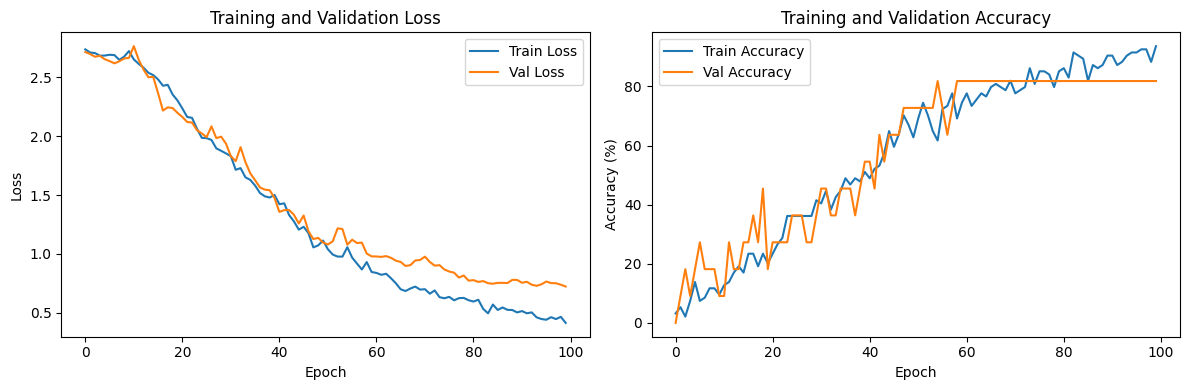


[SUCCESS] THGC-LSTM training completed!
[INFO] Final validation accuracy: 0.8182
[INFO] Model saved as 'best_thgc_lstm.pth' in 'models'


In [8]:
# ========== EVALUATION AND VISUALIZATION ==========
def evaluate_model(model, val_loader, device):
    """Evaluate the trained model"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for keypoints, labels in val_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"[INFO] Final validation accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, zero_division=0))
    
    return accuracy

# Load best model and evaluate
model_path = os.path.join(config.training.save_dir, config.training.model_save_name)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"[INFO] Loaded best model from {model_path}")
else:
    print(f"[WARNING] Model file not found at {model_path}")

final_accuracy = evaluate_model(model, val_loader, device)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n[SUCCESS] THGC-LSTM training completed!")
print(f"[INFO] Final validation accuracy: {final_accuracy:.4f}")
print(f"[INFO] Model saved as '{config.training.model_save_name}' in '{config.training.save_dir}'")